- Setup the environment

In [ ]:
import sys
import os
cur_dir = os.getcwd()
# Add the current directory to system path (including parent folder)
sys.path.append(cur_dir)
sys.path.append(os.path.split(cur_dir)[0])

- Load input data

Create sample data

In [ ]:
import pandas as pd
import numpy as np
# Prepare sample data
timestamp = pd.date_range(start='2020-01-01', periods=300, freq='D')
time_series = pd.DataFrame({'values': np.random.randn(300)}, index=timestamp)
labels = pd.DataFrame({'label': np.random.randint(0, 3, size=300)}, index=timestamp)
ext_features = pd.DataFrame({
    'feature1': np.random.randn(300),
    'feature2': np.random.randn(300)
}, index=timestamp)

combined_data = time_series.join(labels).join(ext_features)

Train / Validation / Test split

In [ ]:
# Train / Validation / Test Split
train_data = combined_data[:100]
val_data = combined_data[100:200]
test_data = combined_data[200:]

# Read targets
train_target = train_data.label.values
val_target = val_data.label.values
test_target = test_data.label.values

# Read features
train_features = train_data[['feature1', 'feature2']].values
val_features = val_data[['feature1', 'feature2']].values
test_features = test_data[['feature1', 'feature2']].values

In [ ]:
from pl_model_utils import TimeSeriesDataModule
# Instantiate data module and model
data_module = TimeSeriesDataModule(
    train_target, train_features,
    val_target, val_features,
    test_target, test_features,
    batch_size=16
)

# Setup the data for model
data_module.setup()

## Classification with Basic Autoencoder

- Compile simple Autoencoder for Classification

In [ ]:
from pl_autoencoder_classifiers import AutoencoderClassifier
ae_model = AutoencoderClassifier(context_length=1, num_classes=3, num_features=2)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint
# Define a checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    monitor='train_loss',
    mode='min',
    save_top_k=1,
    save_last=True,
)

- Train the Autoencoder

In [ ]:
from pytorch_lightning import Trainer
# Train the model
trainer = Trainer(max_epochs=20, callbacks=[checkpoint_callback])
trainer.fit(ae_model, data_module.train_dataloader())

- Cross-Validation (Using Combinatorial Purged K-Fold CV)

In [ ]:
from pl_model_utils import cross_validate_model
from CPCV.cpcv import CombPurgedKFoldCVLocal


pred_times = pd.Series(val_data.index, index=val_data.index)
eval_times = pd.Series(val_data.index, index=val_data.index)

# Construct CPCV in-line with DePrado method
cpcv = CombPurgedKFoldCVLocal(
    n_splits=10,
    n_test_splits=1,
    embargo_td=pd.Timedelta(days=2)
)

cv_split = cpcv.split(
    pd.DataFrame(data_module.val_features, index=val_data.index), 
    pd.Series(data_module.val_target, index=val_data.index), 
    pred_times, 
    eval_times)

# Perform cross-validation
cv_results = cross_validate_model(
    X=data_module.val_features,
    y=data_module.val_target,
    model=ae_model,
    cv_split=cv_split)

In [ ]:
from mc_dropout import mc_dropout # final, one-line function to implement mc dropout (As suggested here: https://github.com/Lightning-AI/pytorch-lightning/blob/f35e2210e240b443fd4dafed8fe2e30ee7d579ea/docs/source/common/production_inference.rst#prediction-api)
predictions_mean, predictions_std = mc_dropout(ae_model, data_module.val_dataloader(), mc_iterations=100)

In [ ]:
np.argmax(predictions_mean, axis=1)

## Classification with Attention-Enchanced Autoencoder

## Hyperparameter Tuning

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping
from pl_autoencoder_classifiers import AutoencoderAttentionClassifier
from pl_model_utils import TimeSeriesDataset
import pytorch_lightning as pl
import torch
from sklearn.model_selection import TimeSeriesSplit
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import log_loss
import optuna
import numpy as np

def ae_attention_objective(trial):
    context_length = 1
    num_classes = 3
    num_features = 2

    # Suggest hyperparameters
    lr = trial.suggest_categorical('lr', [1e-5, 1e-3, 1e-2])
    num_heads = trial.suggest_categorical('num_heads', [1, 2, 4])
    dropout_prob = trial.suggest_categorical('dropout_prob', [0.1, 0.3, 0.5])
    hidden_units = trial.suggest_categorical('hidden_units', [64, 128, 256])
    embed_dim = trial.suggest_categorical('embed_dim', [32, 64, 128])
    classifier_units = trial.suggest_categorical('classifier_units', [16, 32, 64])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Initialize the model with suggested hyperparameters
    model = AutoencoderAttentionClassifier(
        context_length=context_length,
        num_classes=num_classes,
        num_features=num_features,
        num_heads=num_heads,
        dropout_prob=dropout_prob,
        hidden_units=hidden_units,
        embed_dim=embed_dim,
        classifier_units=classifier_units,
        lr=lr
    )

    # Assuming you have your dataset in `X` and `y`
    X, y = data_module.val_features, data_module.val_target
    # X = np.array(X_train)  # Ensure X_train is a NumPy array
    # y = np.array(y_train)  # Ensure y_train is a NumPy array

    # Time series split
    tscv = TimeSeriesSplit(n_splits=5)
    cv_scores = []

    for train_index, val_index in tscv.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]

        # Create DataLoader for the training and validation fold
        train_dataset = TimeSeriesDataset(
            torch.tensor(y_train_fold, dtype=torch.float32), 
            torch.tensor(X_train_fold, dtype=torch.float32)
            )
        
        val_dataset = TimeSeriesDataset(
            torch.tensor(y_val_fold, dtype=torch.float32), 
            torch.tensor(X_val_fold, dtype=torch.float32)
            )
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize trainer
        trainer = pl.Trainer(
            max_epochs=10,
            callbacks=[EarlyStopping(monitor='train_loss', patience=3, mode='min')],
            logger=False,
            enable_checkpointing=False
        )

        # Train the model
        trainer.fit(model, train_loader)

        # Validate the model

        model.eval()
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch in val_loader:
                targets, features = batch
                _, classification = model(targets, features)
                # preds = torch.argmax(classification, dim=1)
                all_preds.extend(classification.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        # val_predictions = trainer.predict(model, val_loader)
        # val_predictions = torch.cat([x for x in val_predictions], dim=0).numpy()
        
        val_loss = log_loss(all_targets, all_preds)
        cv_scores.append(val_loss)

    return np.mean(cv_scores)

In [ ]:
# Run the Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(ae_attention_objective, n_trials=10)

In [ ]:
# Print best hyperparameters
print("Best hyperparameters:", study.best_params)

In [ ]:
ae_attention_model = AutoencoderAttentionClassifier(
    context_length=1, 
    num_classes=3, 
    num_features=2,
    lr=study.best_params['lr'],
    num_heads=study.best_params['num_heads'],
    dropout_prob=study.best_params['dropout_prob'],
    hidden_units=study.best_params['hidden_units'],
    embed_dim=study.best_params['embed_dim'],
    classifier_units=study.best_params['classifier_units']
    )

In [ ]:
ae_attention_model = AutoencoderAttentionClassifier(
    context_length=1, 
    num_classes=3, 
    num_features=2,
    lr=0.001,
    num_heads=1,
    dropout_prob=0.1,
    hidden_units=256,
    embed_dim=128,
    classifier_units=64
    )

In [ ]:
# Train the model
trainer = Trainer(max_epochs=10, callbacks=[checkpoint_callback])
trainer.fit(ae_attention_model, data_module.train_dataloader())

In [ ]:
# Construct CPCV in-line with DePrado method
cpcv = CombPurgedKFoldCVLocal(
    n_splits=10,
    n_test_splits=1,
    embargo_td=pd.Timedelta(days=2)
)

cv_split = cpcv.split(
    pd.DataFrame(data_module.val_features, index=val_data.index), 
    pd.Series(data_module.val_target, index=val_data.index), 
    pred_times, 
    eval_times)


# Perform cross-validation
cv_results = cross_validate_model(
    X=data_module.val_features, 
    y=data_module.val_target, 
    model=ae_attention_model,
    cv_split=cv_split)

In [ ]:
print(cv_results)

In [ ]:
predictions_mean, predictions_std = mc_dropout(ae_attention_model, data_module.val_dataloader(), mc_iterations=100)

In [ ]:
predicted_labels = np.argmax(predictions_mean, axis=1)

In [ ]:
# Example output with probabilities and uncertainty
for i, (mean, std) in enumerate(zip(predictions_mean, predictions_std)):
    # softmax_probs = np.exp(mean) / np.sum(np.exp(mean)) # Softmax to get probabilities
    print(f'Sample {i}: Predicted Label = {predicted_labels[i]}, Probabilities = {mean}, Uncertainty (std) = {std}')

- Export the reults

In [ ]:
import pandas as pd
# Save test predictions to a CSV
test_df = pd.DataFrame({
    'Prediction': predicted_labels,
    'Probability_0': [p[0] for p in predictions_mean],
    'Probability_1': [p[1] for p in predictions_mean],
    'Probability_2': [p[2] for p in predictions_mean],  # Adjust based on num_classes
    'Uncertainty_0': [u[0] for u in predictions_std],
    'Uncertainty_1': [u[1] for u in predictions_std],
    'Uncertainty_2': [u[2] for u in predictions_std] 
})

test_df.to_csv('test_predictions.csv', index=False)

- Export the model

In [ ]:
from torch import save
save(ae_attention_model.state_dict(), 'autoencoder_attention_classifier.pth')

In [ ]:
import h5py

with h5py.File('ae_data.h5', 'w') as f:
    f.create_dataset('X', data=data_module.val_features)
    f.create_dataset('y', data=data_module.val_target)

## Explainable AI Part

In [1]:
import sys
import os
sys.path.append(os.getcwd())

In [2]:
import h5py

with h5py.File('ae_data.h5', 'r') as f:
    X = f['X'][:]
    y = f['y'][:]

In [3]:
from pl_autoencoder_classifiers import AutoencoderAttentionClassifier
from pl_model_utils import TimeSeriesDataset
from torch.utils.data import DataLoader

c:\Users\jedre\miniconda3\envs\GluonTS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import torch
val_dataset = TimeSeriesDataset(
            torch.tensor(y, dtype=torch.float32), 
            torch.tensor(X, dtype=torch.float32)
            )

val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [5]:
batch = next(iter(val_loader))
targets, features = batch

In [6]:
x = torch.cat((
    targets.unsqueeze(1),
    features
), dim=1)

In [7]:
ae_model = AutoencoderAttentionClassifier(
    context_length=1, 
    num_classes=3, 
    num_features=2,
    lr=0.001,
    num_heads=1,
    dropout_prob=0.1,
    hidden_units=256,
    embed_dim=128,
    classifier_units=64)
ae_model.load_state_dict(torch.load('autoencoder_attention_classifier.pth'))
ae_model.eval()

AutoencoderAttentionClassifier(
  (encoder): Sequential(
    (0): Linear(in_features=3, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
  )
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=1, bias=True)
    (3): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=3, bias=True)
  )
  (softmax): Softmax(dim=1)
)

In [8]:
ae_model(x)

tensor([[9.3144e-26, 1.0000e+00, 0.0000e+00],
        [3.7857e-23, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.7932e-28, 1.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [0.0000e+00, 0.0000e+00, 1.0000e+00],
        [2.6104e-24, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00],
        [2.0771e-25, 1.0000e+00, 0.0000e+00],
        [7.8490e-22, 1.0000e+00, 0.0000e+00],
        [3.3915e-21, 1.0000e+00, 0.0000e+00],
        [2.7716e-25, 1.0000e+00, 0.0000e+00],
        [1.0000e+00, 0.0000e+00, 0.0000e+00]], grad_fn=<SoftmaxBackward0>)

In [9]:
import shap

e = shap.DeepExplainer(ae_model, x)

In [10]:
shap_values = e.shap_values(x)

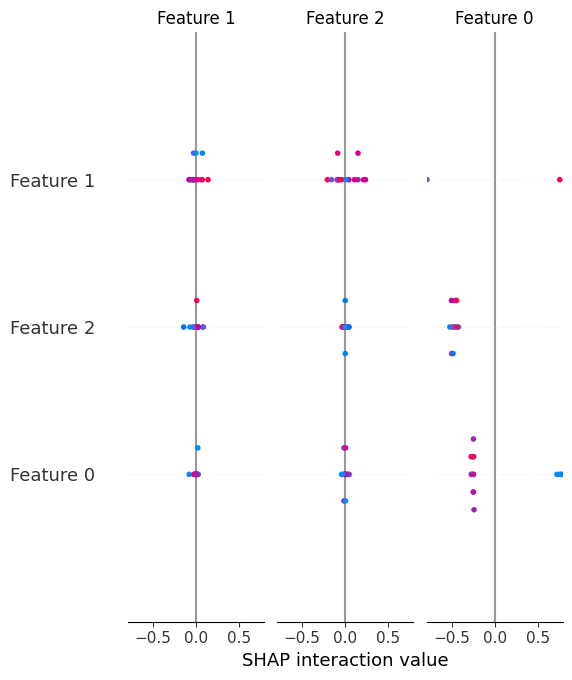

In [11]:
shap.summary_plot(shap_values, x)

In [17]:
def predict_proba(X):
    ae_model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X)
        predictions = ae_model(X_tensor).numpy()

    return np.hstack((1 - predictions, predictions))

In [12]:
from lime import lime_tabular

In [13]:
explainer_lime = lime_tabular.LimeTabularExplainer(
    training_data=x.detach().numpy(), 
    mode='classification',
    feature_names=['Feature_1', 'Feature_2', 'Feature_3'],
    verbose=True)

In [ ]:
type(x.detach().numpy())

In [ ]:
import numpy as np
if type(x.detach().numpy()) == np.ndarray:
    print(True)